In [211]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
from PIL import Image
import cv2

## Prep Data

In [212]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [213]:
testing_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

## Visualize Data

<function matplotlib.pyplot.show(close=None, block=None)>

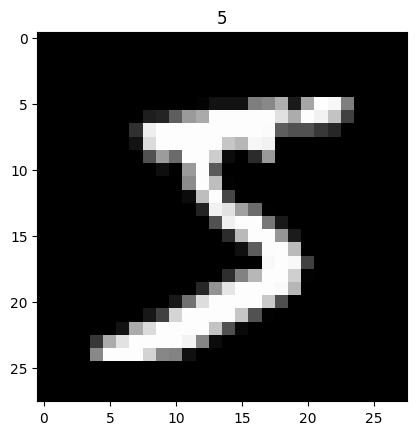

In [214]:
import matplotlib.pyplot as plt

image_num = 0
plt.imshow(training_data.data[image_num], cmap='gray')
plt.title('%i' % training_data.targets[image_num])
plt.show

In [215]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(X.shape)
  print(y.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Create Data Model

In [216]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


## Choose Loss function and Optimizer

In [217]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Train Steps

In [218]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [219]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Train Model

In [220]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.316254  [   64/60000]
loss: 2.308779  [ 6464/60000]
loss: 2.314080  [12864/60000]
loss: 2.277439  [19264/60000]
loss: 2.290716  [25664/60000]
loss: 2.291755  [32064/60000]
loss: 2.283351  [38464/60000]
loss: 2.298866  [44864/60000]
loss: 2.270012  [51264/60000]
loss: 2.271903  [57664/60000]
Test Error: 
 Accuracy: 21.8%, Avg loss: 2.276224 

Epoch 2
-------------------------------
loss: 2.284918  [   64/60000]
loss: 2.277196  [ 6464/60000]
loss: 2.278577  [12864/60000]
loss: 2.238727  [19264/60000]
loss: 2.254731  [25664/60000]
loss: 2.253708  [32064/60000]
loss: 2.237396  [38464/60000]
loss: 2.269799  [44864/60000]
loss: 2.230149  [51264/60000]
loss: 2.218113  [57664/60000]
Test Error: 
 Accuracy: 33.5%, Avg loss: 2.230991 

Epoch 3
-------------------------------
loss: 2.243886  [   64/60000]
loss: 2.228887  [ 6464/60000]
loss: 2.224004  [12864/60000]
loss: 2.179497  [19264/60000]
loss: 2.199622  [25664/60000]
loss: 2.193098  [32064/600

## Save Model

In [226]:
torch.save(model.state_dict(), "mnist_model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Load Model

In [227]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("mnist_model.pth"))

<All keys matched successfully>

## Predict Data

### Use Test Data

Predicted: "9"


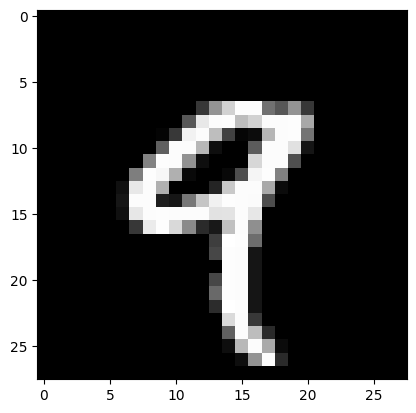

In [228]:
sample = next(iter(test_dataloader))
img, label = sample

index = 4
actual_number = label[index].numpy()

model.eval()
with torch.no_grad():
    pred = model(img[index])
    prediction = torch.max(pred, 1)[1].data.numpy().squeeze()
    print(f'Predicted: "{prediction}"')

    image = img[index].squeeze(0)
    plt.imshow(image, cmap='gray')

### Use Own Digit

In [229]:
def load_image(file):
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

  img_resized = cv2.resize(image, (28, 28), interpolation=cv2.INTER_LINEAR)
  img_resized = cv2.bitwise_not(img_resized)

  img_resized = TF.to_tensor(img_resized)
  return img_resized

Predicted: "8"


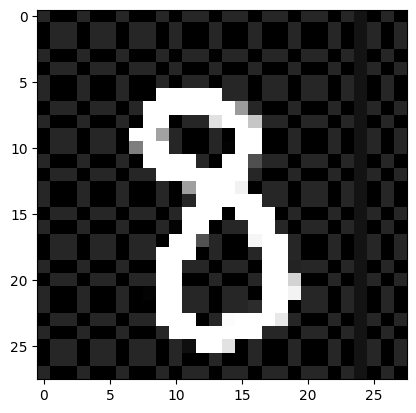

In [230]:
image = load_image(r'/content/sample8.png')

model.eval()
with torch.no_grad():
    pred = model(image)
    prediction = torch.max(pred, 1)[1].data.numpy().squeeze()
    print(f'Predicted: "{prediction}"')

    image = image.squeeze(0)
    plt.imshow(image, cmap='gray')